In [1]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

In [2]:
import sys

sys.path.append("..")

---

In [3]:
import json
from functools import partial

import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import networkx as nx
from icecream import ic

from funcs.utils import find_project_root

from resources.nlp_models import load_scispacy_lg
from scripts.clean_epigraphdb_ents import clean_text

In [4]:
root = find_project_root()
data_dir = root.parent / "data"
assert data_dir.exists()

ebi_dir = data_dir / "gwas-catalog"
gwas_to_efo_path = ebi_dir / "clean_gwas_to_efo.csv"
assert gwas_to_efo_path.exists()

efo_dir = data_dir / "efo"
efo_graph_file = efo_dir / "efo_graph.gpickle"

---

# Encode

In [5]:
nlp = load_scispacy_lg()

2021-06-13 20:35:25.234 | INFO     | funcs.utils:timed:35 - load_scispacy_lg finished in 0.32 mins.


In [6]:
gwas_to_efo = pd.read_csv(gwas_to_efo_path)
print(gwas_to_efo.info())
gwas_to_efo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16871 entries, 0 to 16870
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gwas_name        16871 non-null  object
 1   efo_name         16871 non-null  object
 2   efo_id           16871 non-null  object
 3   parent_efo_name  16871 non-null  object
 4   parent_efo_id    16871 non-null  object
dtypes: object(5)
memory usage: 659.1+ KB
None


,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id
0,Clubfoot,familial clubfoot with or without associated l...,http://www.orpha.net/ORDO/Orphanet_199315,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
1,Alcohol dependence or heroin dependence or met...,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
2,Methamphetamine dependence,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
3,Hypothyroidism,hypothyroidism,http://www.ebi.ac.uk/efo/EFO_0004705,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
4,Age at menopause,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444


In [7]:
def encode(text: str, nlp_model) -> str:
    doc = nlp_model(text)
    if doc.vector is not None:
        return doc.vector.tolist()
    else:
        return []

In [8]:
%%time

gwas_encodes = (
    gwas_to_efo[["gwas_name"]]
    .drop_duplicates()
    .assign(
        clean_text=lambda df: df["gwas_name"].apply(
            lambda x: clean_text(x, nlp_model=nlp)
        )
    )
    .assign(
            vector=lambda df: df["clean_text"].apply(lambda x: encode(x, nlp_model=nlp))
        )
)
print(gwas_encodes.info())
gwas_encodes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13334 entries, 0 to 16870
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gwas_name   13334 non-null  object
 1   clean_text  13334 non-null  object
 2   vector      13334 non-null  object
dtypes: object(3)
memory usage: 416.7+ KB
None
CPU times: user 1min 53s, sys: 340 ms, total: 1min 54s
Wall time: 1min 54s


,gwas_name,clean_text,vector
0,Clubfoot,clubfoot,"[-0.37584900856018066, 0.19428400695323944, -0..."
1,Alcohol dependence or heroin dependence or met...,alcohol dependence or heroin dependence or met...,"[-0.11215012520551682, -0.17538602650165558, 0..."
2,Methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
3,Hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
4,Age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."


In [9]:
output_file = ebi_dir / "gwas_encodes.csv.gz"
gwas_encodes.to_csv(output_file, index=False, compression="gzip")

In [10]:
%%time

efo_encodes = (
    gwas_to_efo[["efo_id", "efo_name"]]
    .drop_duplicates()
    .assign(
        clean_text=lambda df: df["efo_name"].apply(
            lambda x: clean_text(x, nlp_model=nlp)
        )
    )
    .assign(
            vector=lambda df: df["clean_text"].apply(lambda x: encode(x, nlp_model=nlp))
        )
)
print(efo_encodes.info())
efo_encodes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2761 entries, 0 to 16869
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   efo_id      2761 non-null   object
 1   efo_name    2761 non-null   object
 2   clean_text  2761 non-null   object
 3   vector      2761 non-null   object
dtypes: object(4)
memory usage: 107.9+ KB
None
CPU times: user 21.3 s, sys: 85.6 ms, total: 21.4 s
Wall time: 21.4 s


,efo_id,efo_name,clean_text,vector
0,http://www.orpha.net/ORDO/Orphanet_199315,familial clubfoot with or without associated l...,familial clubfoot with or without associate lo...,"[-0.02324697934091091, 0.004608644172549248, -..."
1,http://www.ebi.ac.uk/efo/EFO_0004701,methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
3,http://www.ebi.ac.uk/efo/EFO_0004705,hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
4,http://www.ebi.ac.uk/efo/EFO_0004704,age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."
9,http://www.ebi.ac.uk/efo/EFO_0004703,age at menarche,age at menarche,"[-0.12539799511432648, -0.04193533584475517, -..."


In [11]:
output_file = ebi_dir / "efo_encodes.csv.gz"
efo_encodes.to_csv(output_file, index=False, compression="gzip")

---

# similarity score

In [12]:
gwas_arr = np.stack(np.array(gwas_encodes["vector"].tolist()), axis=0)
print(gwas_arr.shape)
assert gwas_arr[0, :].tolist() == gwas_encodes["vector"][0]

(13334, 200)


In [13]:
efo_arr = np.stack(np.array(efo_encodes["vector"].tolist()), axis=0)
print(efo_arr.shape)
assert efo_arr[0, :].tolist() == efo_encodes["vector"][0]

(2761, 200)


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine as cosine_distance

In [15]:
%%time

similarity_arr = cosine_similarity(gwas_arr, efo_arr)
print(similarity_arr.shape)

(13334, 2761)
CPU times: user 2min 9s, sys: 5min 59s, total: 8min 9s
Wall time: 14.7 s


In [16]:
print(similarity_arr[0, 0])
print(1 - cosine_distance(gwas_encodes["vector"][0], efo_encodes["vector"][0],))

0.5734677237334654
0.5734677237334653


In [17]:
output_file = ebi_dir / "similarity_arr.npy"
np.save(output_file, similarity_arr)

---

# analysis

In [5]:
gwas_encodes_path = ebi_dir / "gwas_encodes.csv.gz"
efo_encodes_path = ebi_dir / "efo_encodes.csv.gz"
gwas_to_efo_path = ebi_dir / "clean_gwas_to_efo.csv"
similarity_arr_path = ebi_dir / "similarity_arr.npy"

In [6]:
gwas_to_efo = pd.read_csv(gwas_to_efo_path)
print(gwas_to_efo.info())
gwas_to_efo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16871 entries, 0 to 16870
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gwas_name        16871 non-null  object
 1   efo_name         16871 non-null  object
 2   efo_id           16871 non-null  object
 3   parent_efo_name  16871 non-null  object
 4   parent_efo_id    16871 non-null  object
dtypes: object(5)
memory usage: 659.1+ KB
None


,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id
0,Clubfoot,familial clubfoot with or without associated l...,http://www.orpha.net/ORDO/Orphanet_199315,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
1,Alcohol dependence or heroin dependence or met...,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
2,Methamphetamine dependence,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
3,Hypothyroidism,hypothyroidism,http://www.ebi.ac.uk/efo/EFO_0004705,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
4,Age at menopause,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444


In [7]:
gwas_encodes = pd.read_csv(gwas_encodes_path).assign(
    vector=lambda df: df["vector"].apply(json.loads)
)
print(gwas_encodes.info())
gwas_encodes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13334 entries, 0 to 13333
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gwas_name   13334 non-null  object
 1   clean_text  13334 non-null  object
 2   vector      13334 non-null  object
dtypes: object(3)
memory usage: 312.6+ KB
None


,gwas_name,clean_text,vector
0,Clubfoot,clubfoot,"[-0.37584900856018066, 0.19428400695323944, -0..."
1,Alcohol dependence or heroin dependence or met...,alcohol dependence or heroin dependence or met...,"[-0.11215012520551682, -0.17538602650165558, 0..."
2,Methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
3,Hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
4,Age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."


In [8]:
efo_encodes = pd.read_csv(efo_encodes_path).assign(
    vector=lambda df: df["vector"].apply(json.loads)
)
print(efo_encodes.info())
efo_encodes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2761 entries, 0 to 2760
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   efo_id      2761 non-null   object
 1   efo_name    2761 non-null   object
 2   clean_text  2761 non-null   object
 3   vector      2761 non-null   object
dtypes: object(4)
memory usage: 86.4+ KB
None


,efo_id,efo_name,clean_text,vector
0,http://www.orpha.net/ORDO/Orphanet_199315,familial clubfoot with or without associated l...,familial clubfoot with or without associate lo...,"[-0.02324697934091091, 0.004608644172549248, -..."
1,http://www.ebi.ac.uk/efo/EFO_0004701,methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
2,http://www.ebi.ac.uk/efo/EFO_0004705,hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
3,http://www.ebi.ac.uk/efo/EFO_0004704,age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."
4,http://www.ebi.ac.uk/efo/EFO_0004703,age at menarche,age at menarche,"[-0.12539799511432648, -0.04193533584475517, -..."


In [9]:
similarity_arr = np.load(similarity_arr_path)

In [10]:
similarity_arr.shape

(13334, 2761)

In [11]:
print(similarity_arr)

[[ 0.57346772 -0.08321398  0.43528596 ...  0.14525737  0.25932941
   0.06446416]
 [ 0.15219263  0.92250771  0.10776712 ...  0.02089715 -0.01034494
   0.15754692]
 [ 0.00778261  1.          0.08975805 ...  0.03561883 -0.03105269
   0.16007295]
 ...
 [ 0.11294115  0.07792424  0.21593123 ... -0.00859792 -0.07831833
   0.03265154]
 [ 0.24552335  0.11146804  0.31138856 ...  0.15902792  0.08289844
   0.16645138]
 [ 0.19952689  0.18990634  0.14023943 ...  0.1246996  -0.02603151
   0.82895111]]


In [12]:
def get_rank(gwas_idx, efo_idx, similarity_arr):
    arr = similarity_arr[gwas_idx, :]
    order = arr.argsort()
    ranks = order.argsort()
    # inverse rank largest to smallest
    efo_idx_rank = len(arr) - ranks[efo_idx]
    return efo_idx_rank

In [13]:
efo_idx_df = efo_encodes[["efo_id"]].reset_index(drop=False).set_index("efo_id")
gwas_idx_df = gwas_encodes[["gwas_name"]].reset_index(drop=False).set_index("gwas_name")
gwas_to_efo = (
    gwas_to_efo.assign(
        efo_idx=lambda df: df["efo_id"].apply(lambda x: efo_idx_df.at[x, "index"]),
        gwas_idx=lambda df: df["gwas_name"].apply(lambda x: gwas_idx_df.at[x, "index"]),
    )
    .assign(
        expected_match_rank=lambda df: df.apply(
            lambda row: get_rank(
                gwas_idx=row["gwas_idx"],
                efo_idx=row["efo_idx"],
                similarity_arr=similarity_arr,
            ),
            axis=1,
        )
    )
    .assign(
        expected_match_rank_bin=lambda df: pd.cut(
            df["expected_match_rank"], bins=[0, 5, 10, 20, float("inf")]
        )
    )
)
gwas_to_efo

,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id,efo_idx,gwas_idx,expected_match_rank,expected_match_rank_bin
0,Clubfoot,familial clubfoot with or without associated l...,http://www.orpha.net/ORDO/Orphanet_199315,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408,0,0,7,"(5.0, 10.0]"
1,Alcohol dependence or heroin dependence or met...,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618,1,1,5,"(0.0, 5.0]"
2,Methamphetamine dependence,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618,1,2,1,"(0.0, 5.0]"
3,Hypothyroidism,hypothyroidism,http://www.ebi.ac.uk/efo/EFO_0004705,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408,2,3,1,"(0.0, 5.0]"
4,Age at menopause,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,3,4,1,"(0.0, 5.0]"
...,...,...,...,...,...,...,...,...,...
16866,Moderate or severe prolonged lymphopenia in di...,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Immune system disorder,http://www.ebi.ac.uk/efo/EFO_0000540,2758,2076,1,"(0.0, 5.0]"
16867,Severe prolonged lymphopenia in dimethyl fumar...,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Immune system disorder,http://www.ebi.ac.uk/efo/EFO_0000540,2758,2077,1,"(0.0, 5.0]"
16868,Surgical necrotising enterocolitis in extremel...,necrotizing enterocolitis,http://www.ebi.ac.uk/efo/EFO_0003928,Digestive system disorder,http://www.ebi.ac.uk/efo/EFO_0000405,2759,13301,4,"(0.0, 5.0]"
16869,Cognitive performance,neuropsychological test,http://www.ebi.ac.uk/efo/EFO_0003926,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,2760,6065,29,"(20.0, inf]"


## analysis: distribution of ranks of the expected match

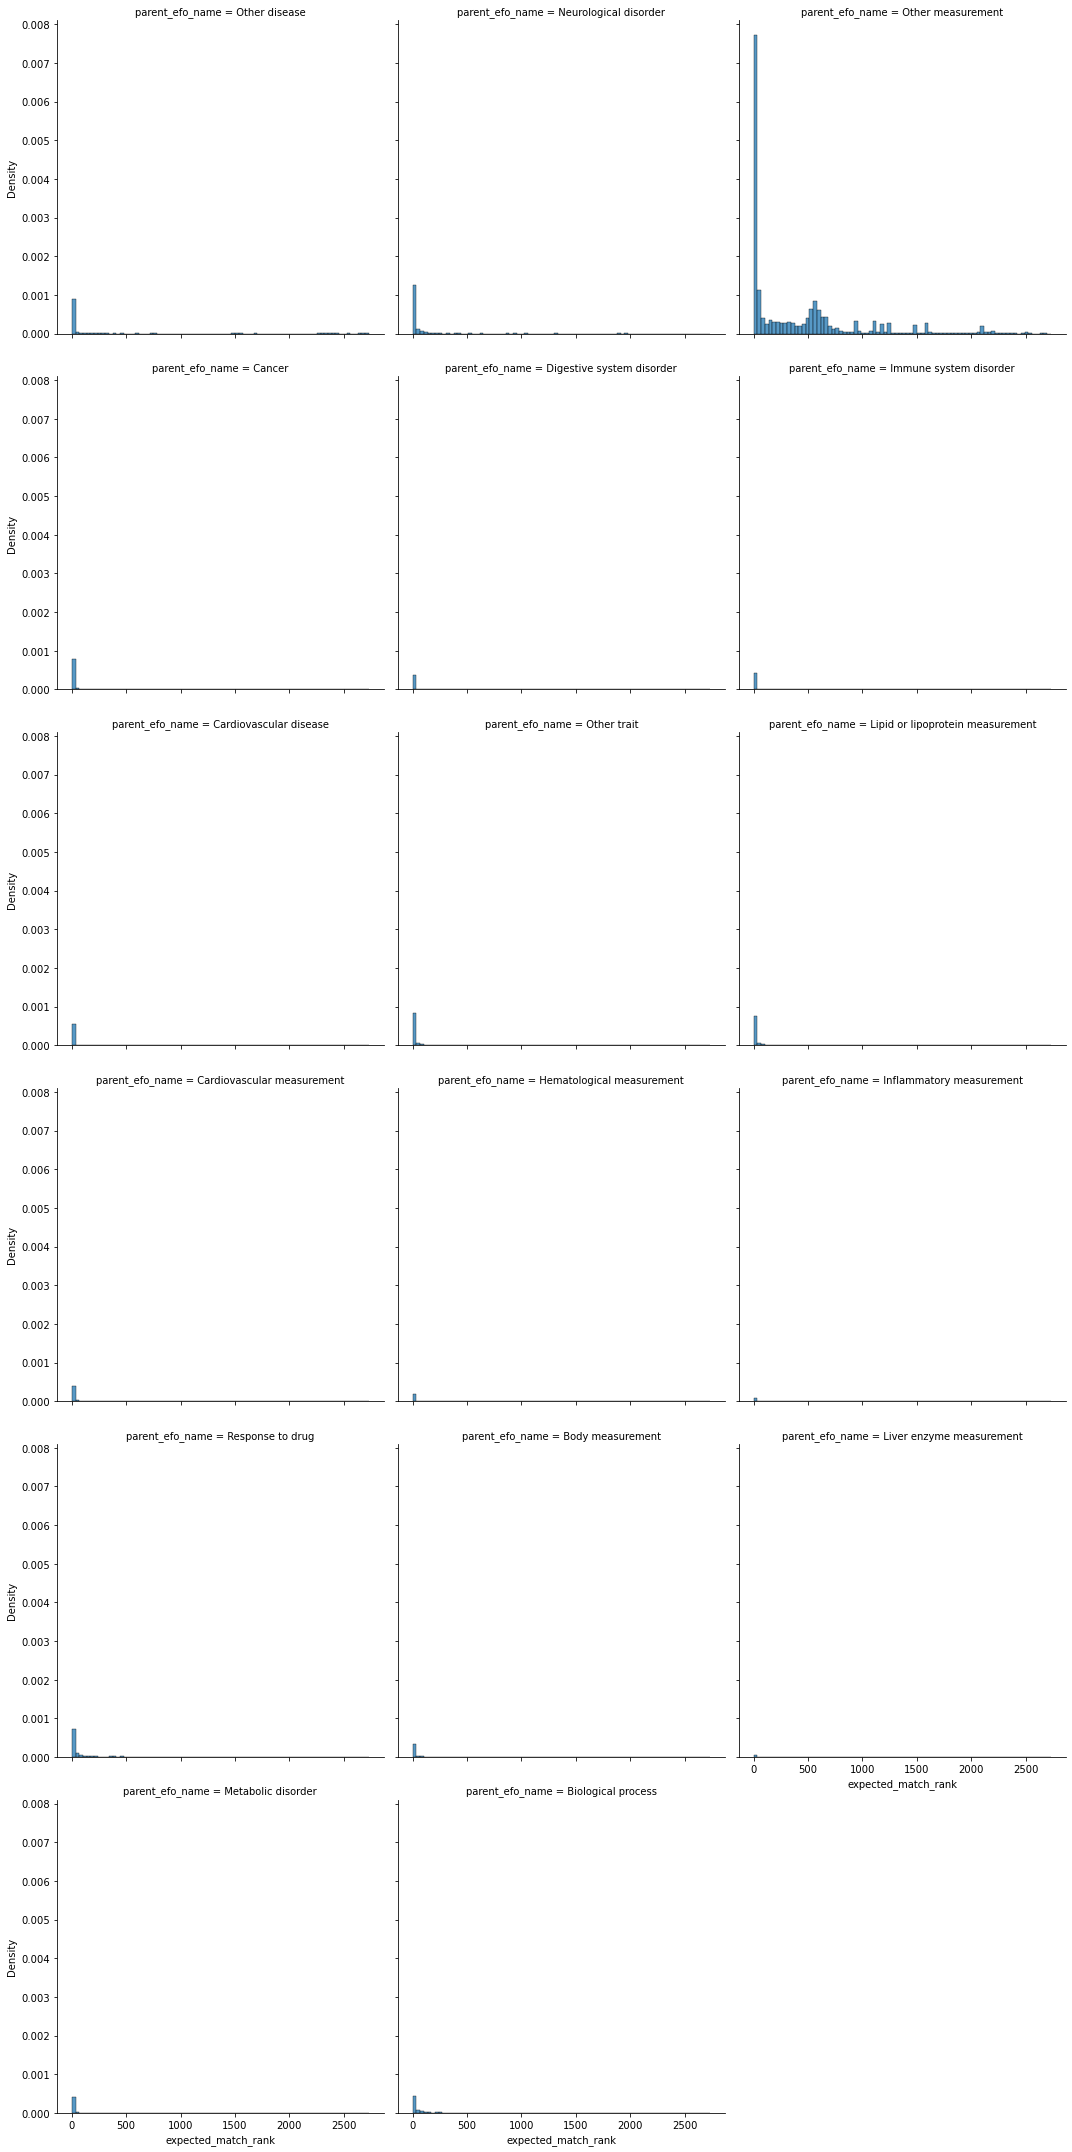

In [14]:
sns.displot(
    data=gwas_to_efo,
    x="expected_match_rank",
    col="parent_efo_name",
    col_wrap=3,
    kind="hist",
    stat="density",
)

In [15]:
s = gwas_to_efo[gwas_to_efo["parent_efo_name"] == "Cancer"]["expected_match_rank"]
print(len(s))
s.value_counts()

510


1      210
2       58
3       26
7       21
4       17
      ... 
53       1
50       1
48       1
489      1
43       1
Name: expected_match_rank, Length: 71, dtype: int64

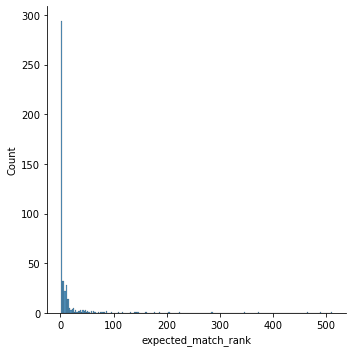

In [16]:
ax = sns.displot(s)

In [17]:
df = (
    gwas_to_efo[["parent_efo_name", "expected_match_rank_bin"]]
    .groupby("parent_efo_name")["expected_match_rank_bin"]
    .value_counts(normalize=True)
    .rename("percent")
    .to_frame()
    .reset_index()
)
df

,parent_efo_name,expected_match_rank_bin,percent
0,Biological process,"(20.0, inf]",0.439086
1,Biological process,"(0.0, 5.0]",0.431472
2,Biological process,"(10.0, 20.0]",0.071066
3,Biological process,"(5.0, 10.0]",0.058376
4,Body measurement,"(0.0, 5.0]",0.611765
...,...,...,...
62,Other trait,"(10.0, 20.0]",0.048561
63,Response to drug,"(20.0, inf]",0.409861
64,Response to drug,"(0.0, 5.0]",0.399076
65,Response to drug,"(10.0, 20.0]",0.100154


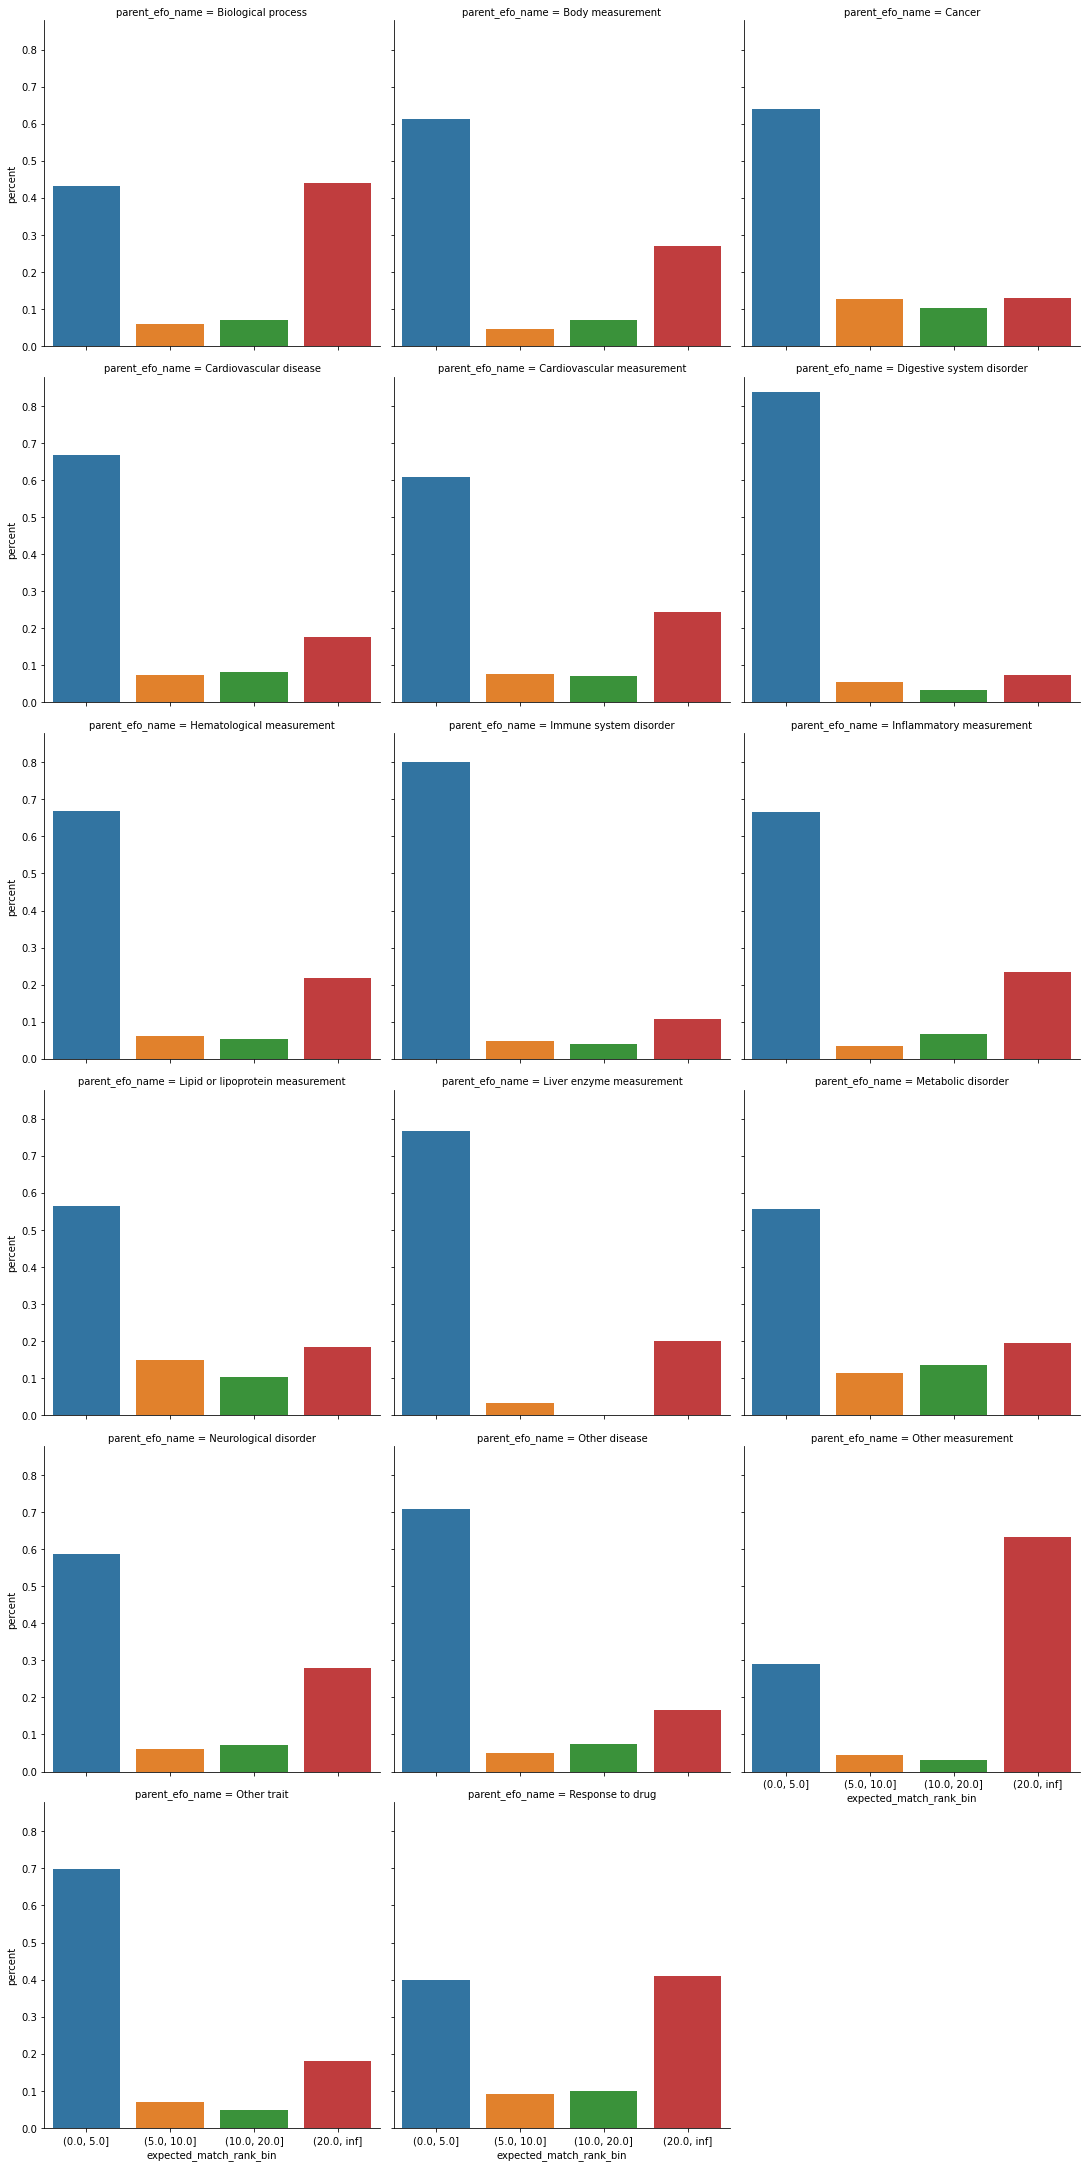

In [18]:
sns.catplot(
    x="expected_match_rank_bin",
    y="percent",
    col="parent_efo_name",
    col_wrap=3,
    data=df,
    kind="bar",
)

# percentage of expected match falling to top rank groups

In [19]:
def top_x(s, cutoff):
    return sum(s.apply(lambda x: x <= cutoff)) / len(s) * 100


top_ranks = (
    gwas_to_efo[["parent_efo_name", "expected_match_rank"]]
    .groupby("parent_efo_name")
    .agg(
        first_3=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=3),
        ),
        first_5=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=5),
        ),
        first_10=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=10),
        ),
    )
)
top_ranks

,first_3,first_5,first_10
parent_efo_name,,,
Biological process,37.309645,43.147208,48.984772
Body measurement,58.431373,61.176471,65.882353
Cancer,57.647059,63.921569,76.666667
Cardiovascular disease,62.889518,66.855524,74.220963
Cardiovascular measurement,53.169014,60.915493,68.661972
Digestive system disorder,77.570093,83.644860,89.252336
Hematological measurement,60.150376,66.917293,72.932331
Immune system disorder,73.033708,80.149813,85.018727
Inflammatory measurement,58.333333,66.666667,70.000000


## analysis: 'wrong' matches

In [20]:
efo_encodes

,efo_id,efo_name,clean_text,vector
0,http://www.orpha.net/ORDO/Orphanet_199315,familial clubfoot with or without associated l...,familial clubfoot with or without associate lo...,"[-0.02324697934091091, 0.004608644172549248, -..."
1,http://www.ebi.ac.uk/efo/EFO_0004701,methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
2,http://www.ebi.ac.uk/efo/EFO_0004705,hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
3,http://www.ebi.ac.uk/efo/EFO_0004704,age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."
4,http://www.ebi.ac.uk/efo/EFO_0004703,age at menarche,age at menarche,"[-0.12539799511432648, -0.04193533584475517, -..."
...,...,...,...,...
2756,http://purl.obolibrary.org/obo/GO_1902521,response to etoposide,response to etoposide,"[-0.11071803420782089, 0.10049143433570862, 0...."
2757,http://purl.obolibrary.org/obo/HP_0011141,age-related cataract,age-related cataract,"[-0.21213899552822113, -0.061980895698070526, ..."
2758,http://www.ebi.ac.uk/efo/EFO_0003929,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,"[-0.23882098495960236, 0.4487026631832123, 0.1..."
2759,http://www.ebi.ac.uk/efo/EFO_0003928,necrotizing enterocolitis,necrotize enterocolitis,"[0.15296250581741333, 0.13960769772529602, -0...."


In [21]:
efo_idx_df

,index
efo_id,
http://www.orpha.net/ORDO/Orphanet_199315,0
http://www.ebi.ac.uk/efo/EFO_0004701,1
http://www.ebi.ac.uk/efo/EFO_0004705,2
http://www.ebi.ac.uk/efo/EFO_0004704,3
http://www.ebi.ac.uk/efo/EFO_0004703,4
...,...
http://purl.obolibrary.org/obo/GO_1902521,2756
http://purl.obolibrary.org/obo/HP_0011141,2757
http://www.ebi.ac.uk/efo/EFO_0003929,2758


In [23]:
arr = np.array([6, 1, 3, 2, 5])
print(arr)
flip_arr = -arr
print(flip_arr)
order = flip_arr.argsort()
print(order)
ranks = order.argsort()
print(ranks)
n = 3
top_n_idx = order[:n]
print(top_n_idx)
top_n_value = arr[top_n_idx]
print(top_n_value)

[6 1 3 2 5]
[-6 -1 -3 -2 -5]
[0 4 2 3 1]
[0 4 2 3 1]
[0 4 2]
[6 5 3]


In [24]:
def get_top_matches(gwas_idx, similarity_arr, efo_idx_df, efo_encodes, top_n=10):
    # ic(gwas_encodes["gwas_name"][gwas_idx])
    arr = similarity_arr[gwas_idx, :]
    # ic(arr)
    flip_arr = -arr
    # ic(flip_arr)
    order = flip_arr.argsort()
    # ic(order)
    ranks = order.argsort()
    # ic(ranks)
    top_ranking_idx = order[:top_n].tolist()
    # ic(top_ranking_idx)
    # ic(arr[top_ranking_idx])
    # ic(arr[0])
    top_ranking_labels = efo_encodes["efo_name"][top_ranking_idx].tolist()
    res = top_ranking_labels
    return res


get_top_matches(0, similarity_arr, efo_idx_df, efo_encodes)

['scoliosis',
 'hallux valgus',
 'adolescent idiopathic scoliosis',
 'hypospadias',
 'esotropia',
 'Non-accomodative esotropia',
 'familial clubfoot with or without associated lower limb anomalies',
 'metopic craniosynostosis',
 'Hemifacial microsomia',
 'strabismus']

In [25]:
df = gwas_to_efo[gwas_to_efo["expected_match_rank"] > 100]
df = df.assign(
    top_matches=lambda df: df["gwas_idx"].apply(
        lambda x: get_top_matches(x, similarity_arr, efo_idx_df, efo_encodes)
    )
)
df

,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id,efo_idx,gwas_idx,expected_match_rank,expected_match_rank_bin,top_matches
5,Aging traits,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,3,5,389,"(20.0, inf]","[complex trait, personality trait, personality..."
68,Lung function (FEV1/FVC),FEV/FEC ratio,http://www.ebi.ac.uk/efo/EFO_0004713,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,8,67,405,"(20.0, inf]","[small cell lung carcinoma, kidney injury mole..."
69,Lung function (FEV1/FVC) in asthma,FEV/FEC ratio,http://www.ebi.ac.uk/efo/EFO_0004713,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,8,68,963,"(20.0, inf]","[lung disease associated with cystic fibrosis,..."
70,Lung function (FEV1/FVC) in asthma (dust mite ...,FEV/FEC ratio,http://www.ebi.ac.uk/efo/EFO_0004713,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,8,69,1613,"(20.0, inf]","[allergen exposure measurement, response to bi..."
71,Lung function (FEV1/FVC) variance,FEV/FEC ratio,http://www.ebi.ac.uk/efo/EFO_0004713,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,8,70,229,"(20.0, inf]","[heart function measurement, pulmonary functio..."
...,...,...,...,...,...,...,...,...,...,...
16793,Docetaxel-induced peripheral neuropathy in met...,response to docetaxel,http://purl.obolibrary.org/obo/GO_1902519,Response to drug,http://purl.obolibrary.org/obo/GO_0042493,2742,12395,159,"(20.0, inf]","[metastatic prostate cancer, metastatic colore..."
16794,Neuropathy in taxane-treated breast cancer,response to docetaxel,http://purl.obolibrary.org/obo/GO_1902519,Response to drug,http://purl.obolibrary.org/obo/GO_0042493,2742,1894,126,"(20.0, inf]","[BRCAX breast cancer, cancer, colorectal cance..."
16795,Persistent chemotherapy-induced alopecia in br...,response to docetaxel,http://purl.obolibrary.org/obo/GO_1902519,Response to drug,http://purl.obolibrary.org/obo/GO_0042493,2742,1896,231,"(20.0, inf]","[chemotherapy-induced alopecia, BRCAX breast c..."
16803,Subclinical atherosclerosis traits (other),ankle brachial index,http://www.ebi.ac.uk/efo/EFO_0003912,Cardiovascular measurement,http://www.ebi.ac.uk/efo/EFO_0004298,2745,3063,1581,"(20.0, inf]","[atherosclerosis, lymphopenia (disease), cardi..."


In [26]:
for idx, row in df.groupby("parent_efo_name").head(4).reset_index(drop=True).iterrows():
    print("{group} #{idx}".format(group=row["parent_efo_name"], idx=idx))
    print(row["gwas_name"], "\t", row["efo_name"], "\t", row["parent_efo_name"])
    print(row["top_matches"])
    print("\n")

Other measurement #0
Aging traits 	 age at menopause 	 Other measurement
['complex trait', 'personality trait', 'personality trait measurement', 'longevity', 'genetic variation', 'parental longevity', 'behavior or behavioral disorder measurement', 'outer ear morphology trait', 'psychological resilience measurement', 'psychosis predisposition measurement']


Other measurement #1
Lung function (FEV1/FVC) 	 FEV/FEC ratio 	 Other measurement
['small cell lung carcinoma', 'kidney injury molecule 1 measurement', 'pulmonary function measurement', 'lung disease associated with cystic fibrosis', 'thyroid function', 'anemia (phenotype)', 'rapid kidney function decline', 'lung adenocarcinoma', 'interstitial lung disease', 'lung carcinoma']


Other measurement #2
Lung function (FEV1/FVC) in asthma 	 FEV/FEC ratio 	 Other measurement
['lung disease associated with cystic fibrosis', 'asthma', 'asthma exacerbation measurement', 'lung disease severity measurement', 'family history of lung cancer', 'in

## analysis: distances of top ranking terms to expected match term

TODO